### Imports and database initialization

In [2]:
from sqlalchemy import select, func, case
from gorillatracker.ssl_pipeline.models import Tracking, Video, Camera
from sqlalchemy.orm import sessionmaker
from gorillatracker.ssl_pipeline.dataset import GorillaDatasetKISZ

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import numpy as np

engine = GorillaDatasetKISZ().engine
session_cls = sessionmaker(bind=engine)

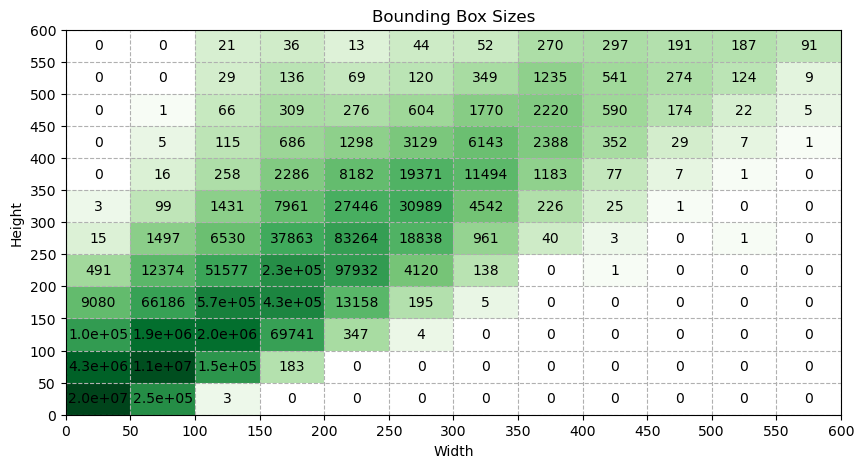

In [6]:
from gorillatracker.ssl_pipeline.models import TrackingFrameFeature
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sqlalchemy import case, select, func
import numpy as np

session = session_cls()

SIZE = 600
STEP = 50
FEATURE_TYPE = "face_45"

# Define the bin edges
bin_edges = list(range(0, SIZE + STEP, STEP))

# Construct a CASE statement for width binning
width_case = case(
    *[
        (TrackingFrameFeature.bbox_width.between(edge, next_edge - 1), edge)
        for edge, next_edge in zip(bin_edges, bin_edges[1:])
    ],
    else_=None,
)

# Construct a CASE statement for height binning
height_case = case(
    *[
        (TrackingFrameFeature.bbox_height.between(edge, next_edge - 1), edge)
        for edge, next_edge in zip(bin_edges, bin_edges[1:])
    ],
    else_=None,
)

# Query the database to get aggregated counts
query = (
    select(width_case.label("width_bin"), height_case.label("height_bin"), func.count().label("count"))
    .where(TrackingFrameFeature.feature_type == FEATURE_TYPE)
    .group_by("width_bin", "height_bin")
)

result = session.execute(query).fetchall()

# Create a 2D array to hold the counts
hist = np.zeros((len(bin_edges) - 1, len(bin_edges) - 1))

# Fill the hist array with the query results
for row in result:
    if row.width_bin is not None and row.height_bin is not None:
        width_index = bin_edges.index(row.width_bin)
        height_index = bin_edges.index(row.height_bin)
        if width_index < len(bin_edges) - 1 and height_index < len(bin_edges) - 1:
            hist[height_index, width_index] = row.count

# Create the histogram
plt.figure(figsize=(10, 5))
norm = LogNorm(vmax=hist.max())
im = plt.imshow(hist, cmap="Greens", norm=norm, extent=[0, SIZE, 0, SIZE], origin="lower", aspect="auto")

# Add text annotations
for i in range(len(bin_edges) - 1):
    for j in range(len(bin_edges) - 1):
        count = int(hist[i, j])
        plt.text(
            bin_edges[j] + STEP // 2,
            bin_edges[i] + STEP // 2,
            f"{count:.1e}" if count >= 99999 else str(count),  # Use scientific notation for large counts
            color="black",
            ha="center",
            va="center",
        )

plt.xlabel("Width")
plt.ylabel("Height")
plt.xticks(bin_edges)
plt.yticks(bin_edges)
plt.title("Bounding Box Sizes")
plt.grid(True, which="both", linestyle="--")
# plt.colorbar(im, label="Count (log scale)")
plt.savefig(f"/workspaces/gorillatracker/notebooks/{FEATURE_TYPE}_bbox_sizes.pdf", format="pdf")
plt.show()

# Close the session
session.close()

### Number of Videos with x tracklets (174 outliers not shown)

In [ ]:
stmt = (
    select(Video.video_id)
)

with session_cls() as session:
    result = session.execute(stmt).fetchall()

num_videos = len(result)

stmt = (
    select(Tracking.video_id, func.count(Tracking.tracking_id).label("count"))
    .group_by(Tracking.video_id)
    )

with session_cls() as session:
    result = session.execute(stmt)
    sorted_all = sorted(result.fetchall(), key=lambda x: x[1], reverse=True)

num_videos_no_tracking = num_videos - len(sorted_all)

res = {}

for video_id, count in sorted_all:
    if count not in res:
        res[count] = 1
    res[count] += 1

res[0] = num_videos_no_tracking

count = sum([res[x] for x in res.keys() if x > 40])
print(count)
print(sorted([(x, res[x]) for x in res.keys() if x > 40]))

res = res.items()

list1, list2 = zip(*res)

plt.bar(list1, list2)
plt.xlabel("Tracklet Count")
plt.ylabel("Number of Videos")
plt.xlim(-1,40)
plt.title("Number of Videos with x Tracklets")
plt.tight_layout()
plt.savefig("/workspaces/gorillatracker/notebooks/tracklet_distribution.pdf", format="pdf")
plt.show()

### Tracklet distribution heatmap over camera positions

In [ ]:
from ipywidgets import IntProgress

stmt = (
    select(Video.camera_id, func.sum(Tracking.tracking_id).label("count"))
    .join(Tracking, Video.video_id == Tracking.video_id)
    .group_by(Video.camera_id)
    )

with session_cls() as session:
    result = session.execute(stmt)
    all = sorted(result.fetchall(), key=lambda x: x[0])

stmt = (
    select(Camera.camera_id, Camera.longitude, Camera.latitude)
    )

with session_cls() as session:
    result = session.execute(stmt)
    all2 = sorted(result.fetchall(), key=lambda x: x[0])

mapping = {x : (y,z) for x, y, z in all2}

f = IntProgress(min=0, max=len(all)) # instantiate the bar
display(f)

points = []
for (camera_id, count) in all:
    f.value += 1
    (long, lat) = mapping[camera_id]
    if long is None or lat is None:
        continue
    for i in range(count//10000):
        points.append((long + np.random.normal(0, 0.002), lat + np.random.normal(0, 0.002)))

x, y = zip(*points)

plt.hist2d(x,y, bins=1000, cmap="twilight")
plt.xlabel("Longitude (2.17km between ticks)")
plt.ylabel("Latitude (2.22km between ticks)")
plt.title("Tracklet distribution heatmap over camera positions")
for i, (x, y) in mapping.items():
    if x is None or y is None:
        continue
    plt.text(x, y, f"{i}", ha="center", fontsize=6)

plt.show()

### Number of Videos per Camera

In [ ]:
stmt = (
    select(Video.camera_id, func.count(Video.video_id).label("count"))
    .group_by(Video.camera_id)
)

with session_cls() as session:
    result = session.execute(stmt)
    result_list = result.fetchall()

sorted_all = sorted(result_list, key=lambda x: x.count, reverse=True)

list1, list2 = zip(*[(row.camera_id, row.count) for row in sorted_all])

plt.xticks(rotation=90, fontsize=4)
plt.bar(range(len(list1)), list2, tick_label=list1)
plt.xlabel("Camera ID")
plt.ylabel("Number of Videos")
plt.title("Number of Videos per Camera")
plt.tight_layout()
plt.savefig("/workspaces/gorillatracker/notebooks/camera_distribution.pdf", format="pdf")
plt.show()

### Length of Videos per Camera

In [ ]:
stmt = (
    select(Video.camera_id, func.avg((Video.frames / Video.fps).label("duration")).label("count"))
    .group_by(Video.camera_id)
)

with session_cls() as session:
    result = session.execute(stmt)
    result_list = result.fetchall()

sorted_all = sorted(result_list, key=lambda x: x.count, reverse=True)

list1, list2 = zip(*[(row.camera_id, row.count) for row in sorted_all])

plt.xticks(rotation=90, fontsize=4)
plt.bar(range(len(list1)), list2, tick_label=list1)
plt.xlabel("Camera ID")
plt.ylabel("Average Video Duration (s)")
plt.title("Average Video Length per Camera")
plt.tight_layout()
plt.savefig("/workspaces/gorillatracker/notebooks/camera_duration_distribution.pdf", format="pdf")
plt.show()

### Length of Videos

In [ ]:
stmt = (
    select((Video.frames / Video.fps).label("duration"), func.count(Video.video_id).label("count"))
    .group_by("duration")
    )

with session_cls() as session:
    result = session.execute(stmt)
    all = result.fetchall()

res = {}

bins = 10
for length, count in all:
    if length // bins * bins not in res:
        res[length // bins * bins] = 0
    res[length // bins * bins] += count

list1, list2 = zip(*res.items())
plt.bar(list1, list2, width=5)
plt.xlabel(f"Length (seconds) in bins of {bins}")
plt.ylabel("Number of Videos (log scale)")
plt.yscale("log")
plt.title("Number of videos per length")
plt.tight_layout()
plt.savefig("/workspaces/gorillatracker/notebooks/video_length_distribution.pdf", format="pdf")
plt.show()

### Distribution of Video Recording Start Times

In [ ]:
from datetime import datetime

stmt = (
    select(Video.start_time)
)

with session_cls() as session:
    result = session.execute(stmt)
    all = result.fetchall()
    all_times = [mdates.date2num(datetime.combine(datetime.today(), t[0].time())) for t in all if t[0] is not None]
    
fig, ax = plt.subplots()
ax.hist(all_times, bins=24 * 4, rwidth=0.8)
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
plt.xlabel("Time of Day Start Time")
plt.ylabel("Number of Videos")
plt.title("Distribution of Video Recording Times")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Number of Videos with and without Camera Position per Date (stacked graph)

In [ ]:
stmt = (
    select(Video.start_time).join(
        Camera, Video.camera_id == Camera.camera_id
        ).where(Video.start_time != None).where(Camera.longitude == None)
    )

with session_cls() as session:
    result = session.execute(stmt)
    no_pos = result.fetchall()
    
stmt = (
    select(Video.start_time).join(
        Camera, Video.camera_id == Camera.camera_id
        ).where(Video.start_time != None).where(Camera.longitude != None)
    )

with session_cls() as session:
    result = session.execute(stmt)
    with_pos = result.fetchall()
    
no_pos_dates = [mdates.date2num(date[0].date()) for date in no_pos if date[0] is not None and date[0].date().year > 2000]
with_pos_dates = [mdates.date2num(date[0].date()) for date in with_pos if date[0] is not None and date[0].date().year > 2000]

fig, ax = plt.subplots()
plt.hist([no_pos_dates, with_pos_dates], bins=100, color=['blue', 'green'], stacked=True)
plt.legend(["Without Camera Position", "With Camera Position"])
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel("Date")
plt.ylabel("Number of Videos")
plt.xticks(rotation=45)
plt.title("Number of videos per date")
plt.tight_layout()
plt.show()